<a href="https://colab.research.google.com/github/kai5gabriel/code_snippets/blob/main/Lstm_agg_gnn_hetero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00


Using device: cpu
HeteroData(
  A={
    x=[100, 10],
    y=[100],
  },
  B={
    x=[80, 15],
    y=[80],
  },
  C={
    x=[120, 8],
    y=[120],
  },
  D={
    x=[90, 12],
    y=[90],
  },
  (A, to, B)={ edge_index=[2, 300] },
  (B, to, C)={ edge_index=[2, 250] },
  (C, to, D)={ edge_index=[2, 350] },
  (D, to, A)={ edge_index=[2, 280] }
)
Epoch 10/100, Loss: 2.0589
Epoch 20/100, Loss: 0.8710
Epoch 30/100, Loss: 0.1780
Epoch 40/100, Loss: 0.0248
Epoch 50/100, Loss: 0.0062
Epoch 60/100, Loss: 0.0028
Epoch 70/100, Loss: 0.0018
Epoch 80/100, Loss: 0.0013
Epoch 90/100, Loss: 0.0011
Epoch 100/100, Loss: 0.0010


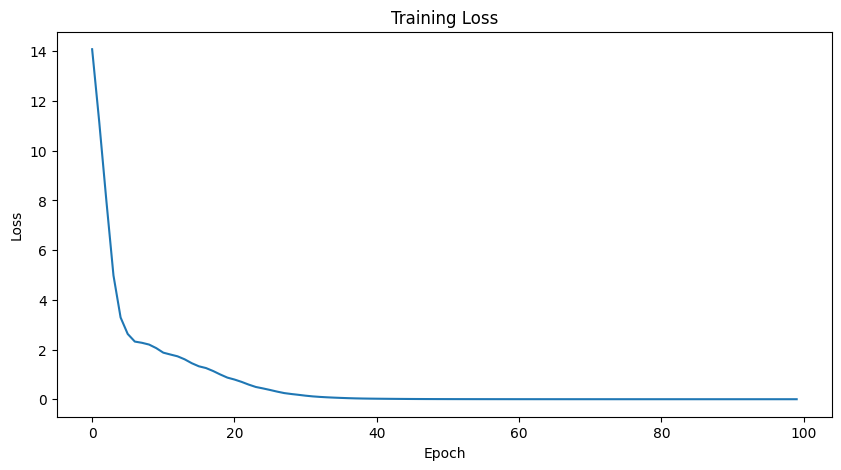


Final output shapes:
B: torch.Size([80, 32])
C: torch.Size([120, 32])
D: torch.Size([90, 32])
A: torch.Size([100, 32])


In [20]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv, Linear
from torch_geometric.data import HeteroData
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def sort_edge_index(data):
    for edge_type in data.edge_types:
        edge_index = data[edge_type].edge_index
        _, sorted_idx = edge_index[1].sort()
        data[edge_type].edge_index = edge_index[:, sorted_idx]
    return data

def create_sample_data():
    data = HeteroData()

    # Create node features for each node type
    data['A'].x = torch.randn(100, 10)
    data['B'].x = torch.randn(80, 15)
    data['C'].x = torch.randn(120, 8)
    data['D'].x = torch.randn(90, 12)

    # Create edge indices for different edge types
    data['A', 'to', 'B'].edge_index = torch.stack([torch.randint(0, 100, (300,)), torch.randint(0, 80, (300,))])
    data['B', 'to', 'C'].edge_index = torch.stack([torch.randint(0, 80, (250,)), torch.randint(0, 120, (250,))])
    data['C', 'to', 'D'].edge_index = torch.stack([torch.randint(0, 120, (350,)), torch.randint(0, 90, (350,))])
    data['D', 'to', 'A'].edge_index = torch.stack([torch.randint(0, 90, (280,)), torch.randint(0, 100, (280,))])

    # Create random target values for each node type
    data['A'].y = torch.randint(0, 2, (100,))
    data['B'].y = torch.randint(0, 2, (80,))
    data['C'].y = torch.randint(0, 2, (120,))
    data['D'].y = torch.randint(0, 2, (90,))

    return sort_edge_index(data)

# Create sample data
hetero_data = create_sample_data()
print(hetero_data)

class GNN(torch.nn.Module):
    def __init__(self, in_channels_dict, hidden_channels, out_channels, metadata):
        super().__init__()

        self.conv1 = HeteroConv({
            edge_type: SAGEConv((in_channels_dict[edge_type[0]], in_channels_dict[edge_type[2]]),
                                hidden_channels)
            for edge_type in metadata[1]
        })

        self.conv2 = HeteroConv({
            edge_type: SAGEConv((hidden_channels, hidden_channels), out_channels)
            for edge_type in metadata[1]
        })

        self.linear = Linear(out_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: x.relu() for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: self.linear(x) for key, x in x_dict.items()}
        return x_dict

# Create the model
in_channels_dict = {node_type: hetero_data[node_type].x.size(1) for node_type in hetero_data.node_types}
model = GNN(in_channels_dict, hidden_channels=64, out_channels=32, metadata=hetero_data.metadata())
model = model.to(device)

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out_dict = model(data.x_dict, data.edge_index_dict)

    loss = 0
    for node_type in data.node_types:
        loss += criterion(out_dict[node_type], data[node_type].y)

    loss.backward()
    optimizer.step()
    return loss.item()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

hetero_data = hetero_data.to(device)

num_epochs = 100
losses = []

for epoch in range(num_epochs):
    loss = train(model, hetero_data, optimizer, criterion)
    losses.append(loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

model.eval()
with torch.no_grad():
    out = model(hetero_data.x_dict, hetero_data.edge_index_dict)

print("\nFinal output shapes:")
for node_type, node_out in out.items():
    print(f"{node_type}: {node_out.shape}")
